In [2]:
import sys
sys.path.append('/Users/gmaurer/GitHub/')
import pyEDIutils.changes as edi
import pyEDIutils.audit_rpts as edia
import pandas as pd
import numpy as np
import datetime as dt

In [3]:
# Set some parameters
start_rpt = '2023-12-01'
end_rpt = '2024-11-30'
annrpt_year = '2024'

## Archive a request for earlier data

Do this if needed to update the request archives to create a full year dataset for the current report .

In [25]:
# Only do this if it isn't archived yet!
edi.archive_requested_changes('2023-11-02', '2024-06-30')

Requesting PASTA changes for knb-lter-jrn from 2023-11-02 to 2024-06-30


KeyboardInterrupt: 

## Load archived requests and most recent data

In [4]:
archived = edi.load_archived_changes()

Reading archived PASTA request knb-lter-jrn_20150417-20181231.xml
Reading archived PASTA request knb-lter-jrn_20190101-20191231.xml
Reading archived PASTA request knb-lter-jrn_20200101-20200601.xml
Reading archived PASTA request knb-lter-jrn_20200602-20201201.xml
Reading archived PASTA request knb-lter-jrn_20201202-20210601.xml
Reading archived PASTA request knb-lter-jrn_20210602-20220101.xml
Reading archived PASTA request knb-lter-jrn_20220102-20220531.xml
Reading archived PASTA request knb-lter-jrn_20220601-20221101.xml
Reading archived PASTA request knb-lter-jrn_20221102-20230315.xml
Reading archived PASTA request knb-lter-jrn_20230316-20230601.xml
Reading archived PASTA request knb-lter-jrn_20230602-20231102.xml
Reading archived PASTA request knb-lter-jrn_20231102-20240630.xml
9 duplicate records were removed.


In [5]:
# Find the last PASTA entry in the archive and convert to datetime
last_archived = pd.to_datetime(archived.date.iloc[-1])

In [6]:
# If the last_archived  value is less than report endtime, get the most recent
# changes (default is retrieve to today) and concatenate to archived requests
if last_archived < pd.to_datetime(end_rpt):
    last_archived_plus1d = last_archived.date() + pd.DateOffset(1)
    # Request changes from last archive to enddate
    new = edi.request_changes(last_archived_plus1d.isoformat())
    if new.empty:
        df = archived.copy()
    else:
        # Concat
        df = pd.concat([archived, new])
else:
    df = archived.copy()
    

Requesting PASTA changes for knb-lter-jrn from 2024-06-07T00:00:00 to None
https://pasta.lternet.edu/package/changes/eml?fromDate=2024-06-07T00%3A00%3A00&toDate=2024-12-01&scope=knb-lter-jrn
0 duplicate records were removed.


In [7]:
# Now create datetime index and subset dataframe
df.index = pd.to_datetime(df['date'])
df = df.loc[start_rpt:end_rpt]

In [8]:
# Convert raw data to counts
df = edi.get_counts(df)
df.tail()


,date,pkgid,action,n_update,n_create,n_delete,n_tot
date,,,,,,,
2024-09-13 08:17:03.335,2024-09-13T08:17:03.335,210548084,updateDataPackage,1,0,0,0
2024-09-13 08:17:24.367,2024-09-13T08:17:24.367,210548054,updateDataPackage,1,0,0,0
2024-09-13 08:17:54.287,2024-09-13T08:17:54.287,210548098,updateDataPackage,1,0,0,0
2024-10-18 22:37:41.652,2024-10-18T22:37:41.652,210616001,createDataPackage,0,1,0,1
2024-10-18 22:43:16.188,2024-10-18T22:43:16.188,210616002,createDataPackage,0,1,0,1


In [9]:
#Get study ids
df['studyid'] = df.pkgid.astype(str).str[-6:-3]

In [10]:
# note that this returns a dataframe with a datetime index
daily = edi.counts_to_daily(df)
daily

,n_update,n_create,n_tot
date,,,
2023-12-01,27,1,1
2023-12-02,117,0,0
2023-12-03,53,0,0
2023-12-04,0,0,0
2023-12-05,0,0,0
...,...,...,...
2024-10-14,0,0,0
2024-10-15,0,0,0
2024-10-16,0,0,0


## Plot activity for annual report


In [11]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

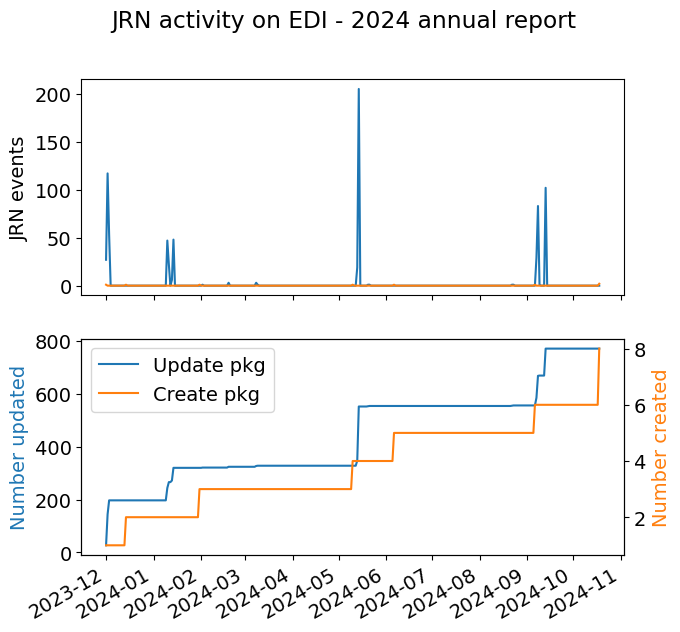

In [12]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update, label='Update pkg')
ax[0].plot(daily.index, daily.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily.index, daily.n_update.cumsum(), label='Update pkg')
plt.ylabel('Number updated', color='C0')
ax2 = ax[1].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create pkg', color='C1')
#ax[1].plot(daily.index, daily.n_tot.cumsum(), label='Total')

plt.ylabel('Number created', color='C1')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI - {0} annual report'.format(annrpt_year))
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
import os
fig.savefig(os.path.expanduser("~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt_{1}.png".format(annrpt_year, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

### Total number of packages

In [13]:
daily.n_create.sum()

8

In [14]:
daily.n_update.sum()

771

## Plot annual activity excluding Met

In [15]:
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
daily_nomet = edi.counts_to_daily(df.loc[nomet], fromdt=start_rpt)

daily_nomet.head()

,n_update,n_create,n_tot
date,,,
2023-12-01,2,1,1
2023-12-02,0,0,0
2023-12-03,0,0,0
2023-12-04,0,0,0
2023-12-05,0,0,0


### Total number of packages

In [16]:
daily_nomet.n_create.sum()

8

In [17]:
daily_nomet.n_update.sum()

13

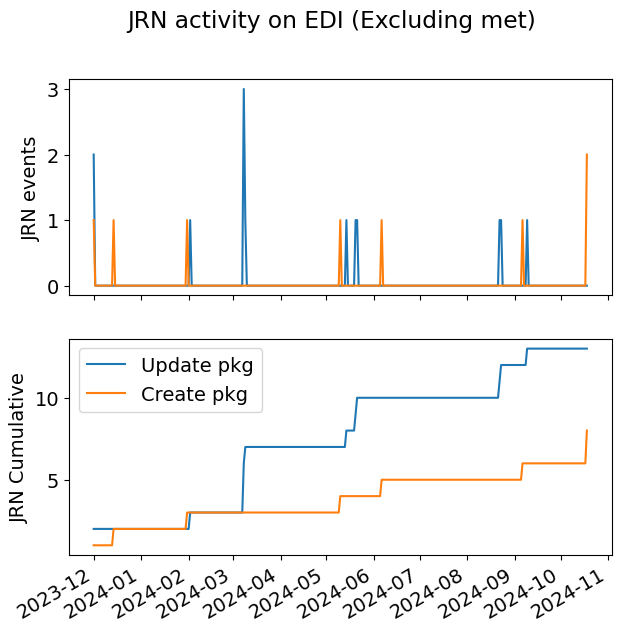

In [18]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_nomet.index, daily_nomet.n_update, label='Update pkg')
ax[0].plot(daily_nomet.index, daily_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_nomet.index, daily_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (Excluding met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt_NoMet_{1}.png".format(annrpt_year, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Summary since last Annual Report

In [19]:
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2023-12-01 01:14:04.280,2023-12-01T01:14:04.28,210465001,createDataPackage,0,1,0,1,465
2023-12-01 21:13:12.637,2023-12-01T21:13:12.637,210380001,updateDataPackage,1,0,0,0,380
2023-12-01 21:37:43.814,2023-12-01T21:37:43.814,210126001,updateDataPackage,1,0,0,0,126
2023-12-01 21:40:17.041,2023-12-01T21:40:17.041,210437033,updateDataPackage,1,0,0,0,437
2023-12-01 21:46:05.048,2023-12-01T21:46:05.048,210437038,updateDataPackage,1,0,0,0,437


In [20]:
# Unique packages updated (excluding met)
rEDI = df.copy()
rEDI_nomet = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.studyid!='548'),:]
print(len(rEDI.loc[rEDI.action=='updateDataPackage',]))
uniqueUp = rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp_nomet = rEDI_nomet.loc[rEDI_nomet.action=='updateDataPackage',].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
print(uniqueUp)
print(uniqueUp_nomet)
print(len(uniqueUp))
len(uniqueUp_nomet)

771
[210380001 210126001 210437033 210437038 210437023 210437009 210437039
 210437024 210437054 210437042 210437027 210437057 210437043 210437055
 210437056 210437058 210437031 210437016 210437046 210437061 210437076
 210437091 210437002 210437032 210437017 210437047 210437062 210437077
 210437092 210437003 210437063 210437093 210437004 210437034 210437049
 210437064 210437079 210437094 210437005 210437106 210437020 210437050
 210437065 210437095 210437006 210437036 210437021 210437051 210437066
 210437081 210437007 210437037 210437022 210437067 210437097 210437008
 210437053 210437068 210437083 210437098 210437069 210437084 210437099
 210437010 210437025 210437070 210437085 210437100 210437041 210437026
 210437071 210437086 210437101 210437012 210437102 210437073 210437088
 210437103 210437014 210437044 210437029 210437059 210437074 210437089
 210437104 210437015 210437045 210437030 210437060 210437090 210437105
 210437107 210437108 210437110 210437111 210437112 210437113 210437114
 2

7

In [21]:
pkgtbl = pd.DataFrame({'Total':[daily.n_create.sum(), daily.n_update.sum(),len(uniqueUp)],
                       'Non-Met':[daily_nomet.n_create.sum(), daily_nomet.n_update.sum(),len(uniqueUp_nomet)]})
pkgtbl.index = ['New packages created', 'Package updates', 'Unique package updates']

print(pkgtbl)
# Write it
with open('tables_out/{}_annrpt_edi.csv'.format(annrpt_year), 'w') as f:
    f.write(pkgtbl.to_csv())

                        Total  Non-Met
New packages created        8        8
Package updates           771       13
Unique package updates    230        7


In [22]:
uniqueUp2 = ['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=' + str(s)
             for s in uniqueUp]
with open('tables_out/{0}AR_unique_EDI_updates_{1}.txt'.format(annrpt_year, now), 'w') as f:
    for item in uniqueUp2:
        f.write("%s\n" % item)
        
uniqueUp2


['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210380001',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210126001',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437033',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437038',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437023',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437009',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437039',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437024',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437054',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437042',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437027',

## Audit reporting

In [23]:
edia.request_audit(210011003)

Requesting access data for knb-lter-jrn.210011003
https://pasta.lternet.edu/audit/reads/knb-lter-jrn/210011003

    


,scope,identifier,revision,resource,total_reads,non_robot_reads
0,knb-lter-jrn,210011003,60,report,50,50
1,knb-lter-jrn,210011003,60,metadata,357,355
2,knb-lter-jrn,210011003,60,data,20,20
3,knb-lter-jrn,210011003,60,dataPackage,129,127
4,knb-lter-jrn,210011003,63,archive,2,2
5,knb-lter-jrn,210011003,63,report,68,67
6,knb-lter-jrn,210011003,63,dataPackage,245,241
7,knb-lter-jrn,210011003,63,data,23,23
8,knb-lter-jrn,210011003,63,metadata,421,416
9,knb-lter-jrn,210011003,101,data,55,55


In [26]:
# Get credentials - these could be anywhere....
import pyEDIutils.edicred as cred

In [27]:
# Get public data downloads for a scope from EDI audit report
# Sometimes this takes 2 tries
test = edia.request_audit_report('readDataEntity', cred.dn, cred.pw,
                               user='public', group=None,resid='knb-lter-jrn',
                               fromdt=start_rpt, todt=end_rpt,lim=100000)

Requesting audit report for knb-lter-jrn starting 2023-12-01
https://pasta.lternet.edu/audit/report/?category=info&service=DataPackageManager-1.0&serviceMethod=readDataEntity&user=public&authSystem=https%3A%2F%2Fpasta.edirepository.org%2Fauthentication&resourceId=knb-lter-jrn&fromTime=2023-12-01&toTime=2024-11-30&limit=100000




In [48]:
# What are the unique useragents and which should we screen out?
test.useragent.unique()

array(['python-requests/2.31.0',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.5735.289 Safari/537.36',
       'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Build/MMB29P) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.6045.123 Mobile Safari/537.36 (compatible; GoogleOther)',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0',
       'DataONE-Python/3.5.2 +http://dataone.org/',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
       'Weecology/Data-Retriever Package Manager: http://www.data-retriever.org/',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
       'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 F

In [101]:
#Exclude DataOne, curl, and python-request agents, which are most likely not 'real users'
searchfor = ['DataONE', 'python-requests', 'curl', 'Turnitin',]
auto_agents = test.useragent.str.contains('|'.join(searchfor), regex=True)
none_vals = test.useragent.values == None
auto_agents[none_vals] = True
auto_agents = auto_agents.astype('bool')
print(auto_agents)
print(len(test))
test_filt = test.loc[~auto_agents.values, :]
#print(len(test_filt))

0         True
1         True
2         True
3         True
4         True
         ...  
43723    False
43724     True
43725    False
43726    False
43727    False
Name: useragent, Length: 43728, dtype: bool
43728


In [100]:
auto_agents.astype('bool')

0         True
1         True
2         True
3         True
4         True
         ...  
43723    False
43724     True
43725    False
43726    False
43727    False
Name: useragent, Length: 43728, dtype: bool

In [102]:
# Calculate the daily values
test_filt.index = pd.to_datetime(test_filt.entry_dt)
test_filt['n'] = 1
print('Average daily public downloads: ', test_filt.shape[0]/365)
test_filt.head()

Average daily public downloads:  94.59452054794521


/var/folders/wj/7fgjbm815wl1ht4n6vcz7jlr0000gn/T/ipykernel_42566/1446458488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filt['n'] = 1


,entry_dt,method,resource_id,user,group,useragent,n
entry_dt,,,,,,,
2023-12-01 01:56:13,2023-12-01T01:56:13,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1
2023-12-01 01:58:42,2023-12-01T01:58:42,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1
2023-12-01 02:01:57,2023-12-01T02:01:57,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1
2023-12-01 06:37:00,2023-12-01T06:37:00,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1
2023-12-01 06:38:05,2023-12-01T06:38:05,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1


In [103]:
dl = test_filt.n.resample('D').count()
dl.head()

entry_dt
2023-12-01     16
2023-12-02     98
2023-12-03     33
2023-12-04    159
2023-12-05    158
Freq: D, Name: n, dtype: int64

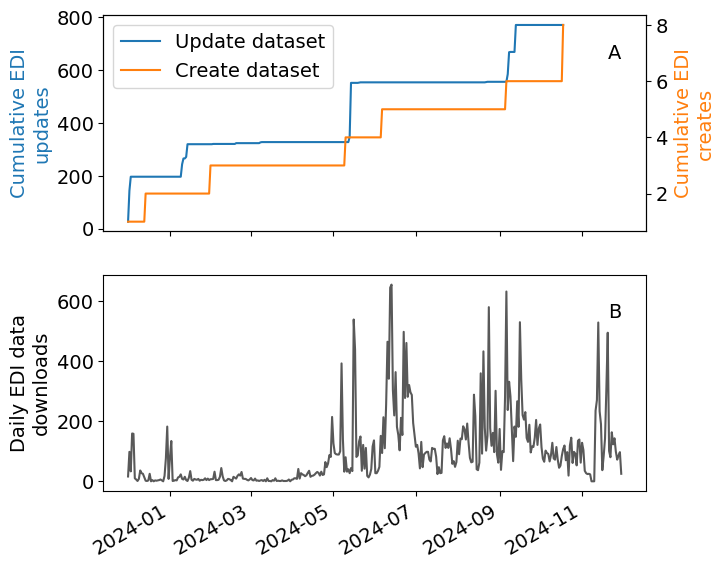

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update.cumsum(), label='Update dataset')
ax2 = ax[0].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create dataset', color='C1')
ax[0].set_ylabel('Cumulative EDI\nupdates', color='C0')
ax2.set_ylabel('Cumulative EDI\ncreates', color='C1')
ax2.text(0.93, 0.8, 'A', transform=ax2.transAxes) 
#ax[0].legend()
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax[1].plot(dl, label='Download pkg', color='0.35')
#ax[1].plot(dl.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

ax[1].set_ylabel('Daily EDI data\ndownloads')
ax[1].text(0.93, 0.8, 'B', transform=ax[1].transAxes) 
fig.autofmt_xdate()
fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt2_{1}.png".format(annrpt_year,now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Get a list of packages updated within the date range

NOTE: this only works for the current annual report! Many packages get updated once per year at least, so they don't show up when running a previous year annual report.

The list is still available in the yearly "AR_unique_EDI_updates.csv"

If we could check prior revisions....

In [21]:
st = pd.to_datetime(start_rpt).isoformat() + 'Z'
en = pd.to_datetime(end_rpt).isoformat() + 'Z'
en

'2024-11-30T00:00:00Z'

In [22]:
import pyEDIutils.search as edis
updates = edis.search_pasta(query=['scope:knb-lter-jrn', 'pubdate:[{0} TO {1}]'.format(st, en)],
                  fields=('packageid','title','pubdate','keyword','author','begindate','enddate','doi'),
                  sortby='packageid,desc')
updates.to_csv('tables_out/{0}_PASTA_updates_solrsearch_{1}.csv'.format(annrpt_year, now))
updates

https://pasta.lternet.edu/package/search/eml?defType=edismax&q=%2A&fq=scope%3Aknb-lter-jrn&fq=pubdate%3A%5B2023-12-01T00%3A00%3A00Z+TO+2024-11-30T00%3A00%3A00Z%5D&fl=packageid%2Ctitle%2Cpubdate%2Ckeyword%2Cauthor%2Cbegindate%2Cenddate%2Cdoi&sort=packageid%2Cdesc&rows=500


,packageid,title,pubdate,keywords,authors,begindate,enddate,doi
0,knb-lter-jrn.210616002.1,Soil physical and chemical properties of gypsu...,2024,Chihuahuan Desert;gypsum soils;Jornada Basin;J...,"Gobbie, Katelyn G;Pietrasiak, Nicole;Drenovsky...",2023-05-17,2023-06-09,doi:10.6073/pasta/01123dd2785f8ff3cb314a837d3b...
1,knb-lter-jrn.210616001.1,Cover and frequency of biological soil crust c...,2024,JRN LTER;Jornada Basin;White Sands National Pa...,"Gobbie, Katelyn G;Drenovsky, Rebecca E;Pietras...",2023-05-17,2023-06-09,doi:10.6073/pasta/488c8b229fed3e872a57a9125986...
2,knb-lter-jrn.210578001.1,"Physical soil characteristics, microbial commu...",2024,inorganic nutrients;biogeochemistry;geomorphol...,"Stover, Dylan;McLaren, Jennie;Pietrasiak, Nico...",2021-06-01,2022-06-30,doi:10.6073/pasta/9085a63e6ff1e310f13784b6fa0f...
3,knb-lter-jrn.210548103.31,Jornada Basin LTER Cross-scale Interactions St...,2024,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2024-09-02,doi:10.6073/pasta/00e34665d21ffb748260fb663e48...
4,knb-lter-jrn.210548102.31,Jornada Basin LTER Cross-scale Interactions St...,2024,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2024-09-02,doi:10.6073/pasta/6eb5d55c2548ce5260d3cdc50e91...
...,...,...,...,...,...,...,...,...
231,knb-lter-jrn.210262004.95,Annual Aboveground Net Primary Productivity by...,2024,Primary Production;populations;aboveground pro...,"Bestelmeyer, Brandon T;Schooley, Robert",2006-05-19,2023-10-24,doi:10.6073/pasta/3fcf0fee94238b6f1c1673636ed6...
232,knb-lter-jrn.210262001.11,Spring and Fall plant cover across grassland-s...,2024,Primary Production;populations;aboveground pro...,"Bestelmeyer, Brandon T;Schooley, Robert",2005-06-01,2023-10-24,doi:10.6073/pasta/13a6e606f3173f5b39cca500ad65...
233,knb-lter-jrn.210126001.131,Jornada Basin LTER Weather Station Daily summa...,2024,air temperature;meteorology;wind direction;win...,"Anderson, John",1983-03-01,2024-09-08,doi:10.6073/pasta/a1fd79442c6ac4433a1844df9188...
234,knb-lter-jrn.200050001.1,Optimizing sampling across methods improves th...,2024,transects;Core Methods;line-point intercept;sa...,"McCord, Sarah E;Webb, Nick;Van Zee, Justin;Cou...",2015-07-01,2023-07-31,doi:10.6073/pasta/b8b8abc0471c826c755788c3f24a...
